In [7]:
# 📦 Install XGBoost (if needed)
!pip install xgboost --quiet

# ✅ Import libraries
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


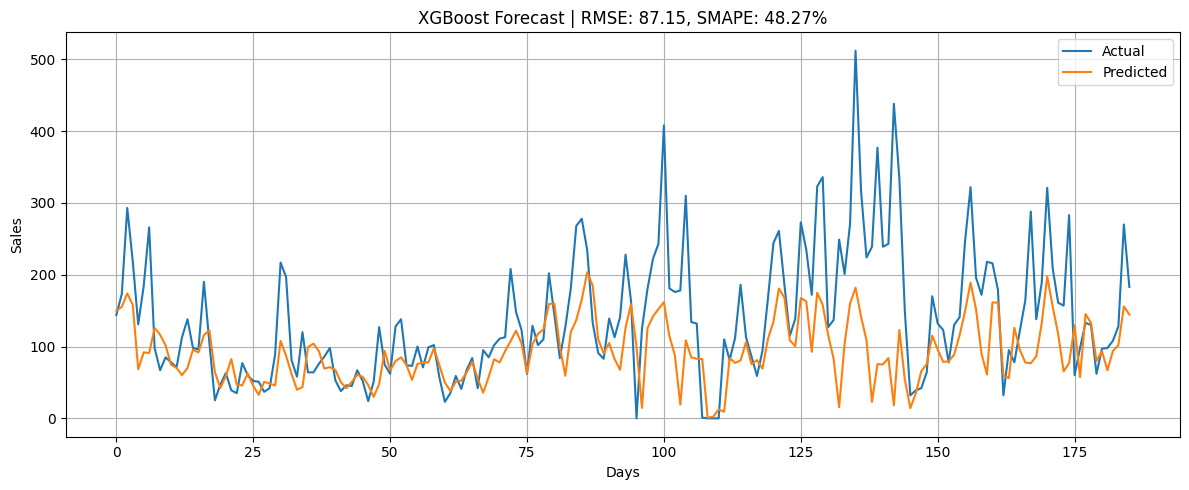

✅ Final RMSE: 87.15
✅ Final SMAPE: 48.27%


In [8]:

# ✅ Load dataset (after uploading)
df = pd.read_csv('/content/mock_kaggle.csv')
df['data'] = pd.to_datetime(df['data'])
df = df.sort_values('data')

# ✅ Feature engineering
df['day'] = df['data'].dt.day
df['month'] = df['data'].dt.month
df['year'] = df['data'].dt.year
df['dayofweek'] = df['data'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# ✅ Lag features
df['lag1'] = df['venda'].shift(1)
df['lag3'] = df['venda'].shift(3)
df['lag7'] = df['venda'].shift(7)

# ✅ Rolling averages
df['rolling7'] = df['venda'].rolling(window=7).mean()

# ✅ Clean
df = df.dropna()

# ✅ Define features and log target
features = ['day', 'month', 'year', 'dayofweek', 'is_weekend',
            'lag1', 'lag3', 'lag7', 'rolling7', 'estoque', 'preco']

X = df[features]
y = np.log1p(df['venda'])  # log-transform

# ✅ Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ✅ Train XGBoost
model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# ✅ Predict + inverse log
y_pred = np.expm1(model.predict(X_test))
y_test = np.expm1(y_test)

# ✅ Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
smape_val = smape(y_test, y_pred)

# ✅ Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title(f"XGBoost Forecast | RMSE: {rmse:.2f}, SMAPE: {smape_val:.2f}%")
plt.xlabel('Days')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Print metrics
print(f"✅ Final RMSE: {rmse:.2f}")
print(f"✅ Final SMAPE: {smape_val:.2f}%")
